## EOF

[https://climatedataguide.ucar.edu/climate-tools/empirical-orthogonal-function-eof-analysis-and-rotated-eof-analysis]
[https://www.wimsoft.com/Course/3/Exercises_WAM_EOF.pdf]
[https://en.wikipedia.org/wiki/Empirical_orthogonal_functions]
[https://www.sciencedirect.com/science/article/abs/pii/B9780123850225000129]

1. Was sind EOFs (Empirical Orthogonal Functions)?

EOFs (auch oft als Principal Component Analysis, PCA, bezeichnet) sind eine Methode, um die dominierenden räumlich-zeitlichen Variationsmuster in einer Datengröße zu extrahieren. In der Ozeanographie wendet man EOF-Analysen häufig auf Felder wie Meerestemperatur (SST), Meeresspiegelanomalien (SLA), Salinität usw. an, um die Hauptvarianzmodi zu identifizieren (z. B. ENSO, PDO usw.).

Konkret zerlegt man dabei eine Datendatenmatrix XX (Zeit × Raum) in orthogonale Basisfunktionen (EOFs) und dazugehörige Zeitserien (Principal Components, PCs). Mathematisch entspricht dies einer Eigenwertzerlegung der Kovarianz- (oder Korrelations-)Matrix der Daten.

3. Überblick über den Workflow

    Daten einlesen (z. B. SST aus NetCDF mit xarray.open_dataset)

    Datenvorverarbeitung

        Auswahl von Region/Zeitraum

        ggf. Filtern von Regionen mit Landmasken

        Entfernen des Klimamittelwerts (Anomalie-Bildung)

        ggf. Entfernen eines linearen Trends oder einer saisonalen Komponente

    Datenmatrix aufbauen

        Zeitpunkte entlang der Zeilen, räumliche Gitterpunkte entlang der Spalten

        Dabei flach legende („stack“) der räumlichen Dimensionen

    EOF-Berechnung

        Wahl: eofs oder sklearn.decomposition.PCA

        Berechnung der EOFs (räumliche Muster) und PCs (Zeitreihen)

        Varianzanteile und kumulative Varianz

    Visualisierung und Interpretation

        Plotten der ersten EOF-Maps (z. B. Weltkarte / Regionalkarte)

        Plotten der entsprechenden PC-Zeitserien

        Erklärung, welche physikalischen Prozesse diese Moden repräsentieren könnten

4. Schritt-für-Schritt-Beispiel mit Python

Im Folgenden zeigen wir ein Beispiel, in dem wir simuliert ein Setup für SST-Daten (Meerestemperatur) verwenden. Du kannst nach diesem Schema deine eigenen NetCDF-Daten einlesen.

In [ ]:
# import all necessary libraries
import os
import warnings
from pathlib import Path

import cartopy.feature as cfeature
import geodatasets
import geopandas as gpd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import xarray as xr
from joblib import Parallel, delayed
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm
from utils.eda_helper_functions import plot_histogram

from utils.eda_helper_functions import (
    check_missing_times,
    group_data_hourly,
    load_insitu_data,
    load_ocean_data,
    load_weather_data,
    plot_water_level_anomalies,
    process_df,
    process_flensburg_data,
    show_df,
)
from utils.config import (
    LAT_FLENSBURG,
    LON_FLENSBURG,
    SUB_BOX,
    OCEAN_DICT,
    WEATHER_DICT,
    INSITU_DICT,
    OCEAN_POINTS,
    WEATHER_POINTS,
    )

# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns
pd.options.display.max_columns = None

from utils.ml_helper_functions import (
    convert_df_to_table,
    feature_engineering,
    merge_dataframes,
)


plt.rcParams.update({
    "font.size": 14,                # Grundschriftgröße (wirkt auf alles, sofern nicht überschrieben)
    "axes.titlesize": 16,           # Größe des Titels der Achse (z.B. 'Subplot Title')
    "axes.labelsize": 14,           # Achsenbeschriftung (x/y label)
    "xtick.labelsize": 12,          # X-Tick-Beschriftung
    "ytick.labelsize": 12,          # Y-Tick-Beschriftung
    "legend.fontsize": 12,          # Legendentext
    "figure.titlesize": 18,         # Gesamttitel der Abbildung (plt.suptitle)
    "figure.labelsize": 14,         # (optional, selten verwendet)
    "savefig.dpi": 300,             # DPI beim Speichern
    "figure.dpi": 100,              # DPI bei Anzeige
})

OCEAN_POINTS = 30
ocean_data_path = Path(f"../data/numerical_data/points{OCEAN_POINTS}")
print(ocean_data_path)
weather_data_path = Path(f"../data/numerical_data/points{WEATHER_POINTS}")
print(weather_data_path)

../data/numerical_data/points30
../data/numerical_data/points10


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Für EOF-Analyse: wir nutzen hier die eofs-Bibliothek
from eofs.xarray import Eof



In [3]:
df_ocean = load_ocean_data(ocean_data_path, OCEAN_POINTS, verbose=False)
df_ocean = process_df(df_ocean, drop_cols=["depth"], verbose=False)

df_weather = load_weather_data(weather_data_path, WEATHER_POINTS, verbose=False)
df_weather = process_df(df_weather, verbose=False, drop_cols=['showers'])

df_insitu = load_insitu_data(verbose=False)
df_insitu = process_flensburg_data(df_insitu, 
                                    start_time=df_ocean['time'].min(),
                                    end_time=df_ocean['time'].max(),
                                    verbose=False)

df_insitu = group_data_hourly(df_insitu)
df_insitu = process_df(df_insitu, drop_cols=["depth",'deph', 'latitude', 'longitude', 'time_qc', 'slev_qc'], verbose=False)



print("\nFeature engineering...")
df_ocean, df_weather, df_insitu = feature_engineering(df_ocean, df_weather, df_insitu)



Feature engineering...

Dropping columns: ['snowfall', 'siconc', 'rain', 'sithick', 'precipitation', 'weather_code', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_high', 'cloud_cover_mid', 'vapour_pressure_deficit', 'et0_fao_evapotranspiration', 'relative_humidity_2m', 'temperature_2m', 'dew_point_2m', 'apparent_temperature', 'mlotst']

Shapes of DataFrames after dropping columns:
Ocean DataFrame: (9415187, 11)
Weather DataFrame: (2018400, 8)
Insitu DataFrame: (20161, 2)


In [4]:
def convert_to_xarray(df):
    """
    Convert a DataFrame to an xarray DataArray.
    """
    df['time'] = pd.to_datetime(df['time'])

    # Optional: Setze einen MultiIndex, falls du nach Zeit, Breite, Länge strukturieren willst
    df = df.set_index(['time', 'latitude', 'longitude'])

    # In ein xarray.Dataset umwandeln:
    ds = df.to_xarray()

    return ds

In [5]:
# Angenommen, df_ocean ist dein DataFrame (wie oben gezeigt)
# Falls 'time' noch nicht als DatetimeIndex gesetzt ist:
ds_ocean = convert_to_xarray(df_ocean)
ds_weather = convert_to_xarray(df_weather)


In [6]:
print(ds_ocean)
print(ds_weather)

<xarray.Dataset> Size: 639MB
Dimensions:    (time: 20161, latitude: 33, longitude: 30)
Coordinates:
  * time       (time) datetime64[ns] 161kB 2022-12-03 ... 2025-03-22
  * latitude   (latitude) float32 132B 53.72 53.94 54.17 ... 59.56 59.77 60.01
  * longitude  (longitude) float32 120B 9.097 9.569 10.04 ... 22.04 22.51 22.99
Data variables:
    bottomT    (time, latitude, longitude) float32 80MB nan nan ... nan 1.237
    sla        (time, latitude, longitude) float32 80MB nan nan ... nan -0.1225
    so         (time, latitude, longitude) float32 80MB nan nan ... nan 3.865
    sob        (time, latitude, longitude) float32 80MB nan nan ... nan 4.504
    thetao     (time, latitude, longitude) float32 80MB nan nan nan ... nan 1.52
    uo         (time, latitude, longitude) float32 80MB nan nan ... nan -0.01419
    vo         (time, latitude, longitude) float32 80MB nan nan ... nan 0.01045
    wo         (time, latitude, longitude) float32 80MB nan nan ... 1.011e-08
<xarray.Dataset> Size:

In [7]:
print(ds_weather)

<xarray.Dataset> Size: 400MB
Dimensions:           (time: 20184, latitude: 10, longitude: 99)
Coordinates:
  * time              (time) datetime64[ns] 161kB 2022-12-03 ... 2025-03-22T2...
  * latitude          (latitude) float32 40B 53.53 54.24 54.94 ... 59.3 60.0
  * longitude         (longitude) float32 396B 8.979 9.12 9.123 ... 23.08 23.1
Data variables:
    pressure_msl      (time, latitude, longitude) float32 80MB nan ... nan
    surface_pressure  (time, latitude, longitude) float32 80MB nan ... nan
    wind_gusts_10m    (time, latitude, longitude) float32 80MB nan 28.8 ... nan
    wind_u            (time, latitude, longitude) float32 80MB nan 14.4 ... nan
    wind_v            (time, latitude, longitude) float32 80MB nan 5.76 ... nan


In [8]:
def eof_solver(ds, feature, center=False, n_modes=10):
    """
    Perform EOF analysis on a given feature of an xarray Dataset.
    """
    # Maske für gültige Ozeanpunkte
    mask = ~np.isnan(ds[feature].isel(time=0))
    ds_cleaned = ds[feature].where(mask)

    # Flächengewichtung nach Breite (broadcast auf (lat, lon))
    lat_deg = ds_cleaned["latitude"].values  # (n_lat,)
    weights_2d = np.sqrt(np.cos(np.deg2rad(lat_deg)))[:, np.newaxis]  # (n_lat, 1)

    # Eof-Objekt erzeugen
    solver = Eof(ds_cleaned, weights=weights_2d, center=center)
    return solver

In [9]:

solver = eof_solver(ds_ocean, 'sla', center=True)

In [ ]:
import numpy as np
import xarray as xr
from eofs.xarray import Eof
import pandas as pd

# Disclaimer: This code was setup with the help of AI Methods!

# --- (A) Solver initialisieren ---
# ds_cleaned: dein vorverarbeiteter DataArray oder Dataset (time, lat, lon), bereits anomaliesiert
# weights: 1D-Array über latitude für Flächengewichtung (z.B. sqrt(cos(lat)))
solver = eof_solver(ds_ocean, 'sla', center=True)

# --- (B) Varianzanteile anschauen, um k zu wählen ---
navors = 30
var_frac = solver.varianceFraction(neigs=navors)
cumvar = var_frac.cumsum(dim="mode")

thresh = 0.9  # Schwellenwert für kumulative Varianz
# z.B. suche k, um ≥95 % abzudecken:
k = int((cumvar >= thresh).argmax().item() + 1)
print(f"Modi für ≥90 % Varianz: {k}")


# --- (C) EOF-Muster und PCs berechnen ---
eofs = solver.eofsAsCovariance(neofs=k)   # (mode:3, lat, lon)
pcs  = solver.pcs(npcs=k, pcscaling=1)    # (time:20184, mode:3)

# --- (E) PCs als reduzierte Features extrahieren ---
# In pandas DataFrame umwandeln, so dass jede Mode eine Spalte wird:
pc_df = pcs.to_dataframe(name="PC").unstack("mode")  
# Alternativ: direkt als NumPy-Array:
pc_array = pc_df.values  # shape = (20184, k)

# Jetzt sind pc_array bzw. pc_df dein endgültiges, niedrig-dimensionales Feature-Set.

# convert to dataframe
df_pc = pc_df.reset_index()
df_pc.columns = ['time'] + [f'sla_PC_{i+1}' for i in range(df_pc.shape[1] - 1)]


Modi für ≥90 % Varianz: 3


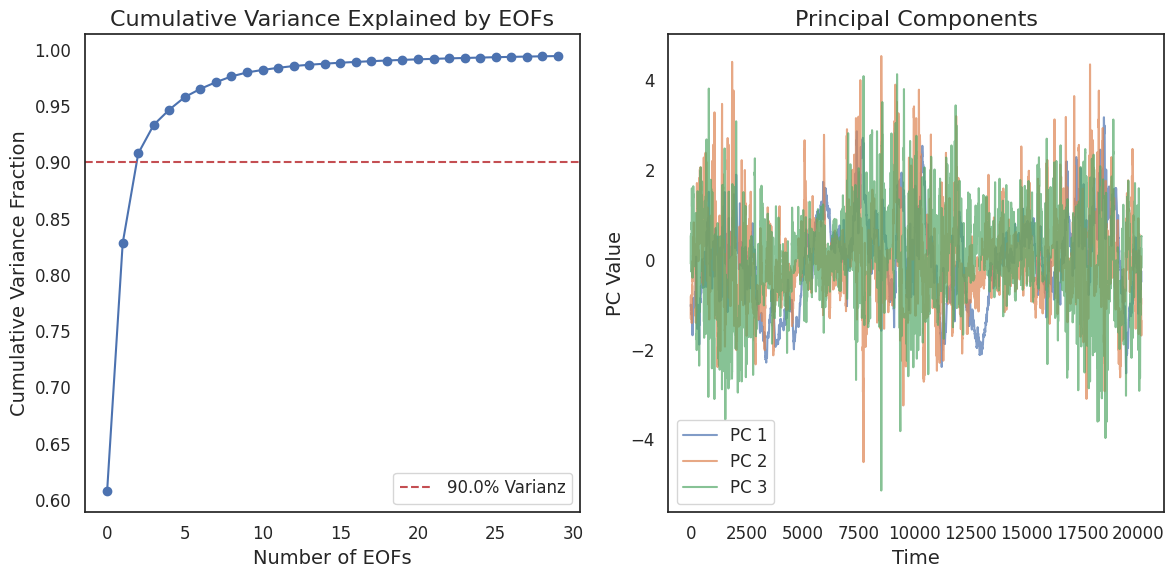

In [20]:
# Plot variance and pcs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cumvar, marker='o')
plt.axhline(thresh, color='r', linestyle='--', label=f'{thresh*100}% Varianz')
plt.title('Cumulative Variance Explained by EOFs')
plt.xlabel('Number of EOFs')
plt.ylabel('Cumulative Variance Fraction')
plt.legend()
plt.subplot(1, 2, 2)
for i in range(k):
    plt.plot(pcs[:, i], label=f'PC {i+1}', alpha=0.7)
plt.title('Principal Components')
plt.xlabel('Time')
plt.ylabel('PC Value')
plt.legend()
plt.tight_layout()
plt.show()




In [21]:
pc_array

array([[-1.005268  , -0.8229236 ,  0.5300699 ],
       [-1.0028113 , -0.8339096 ,  0.52825636],
       [-1.006549  , -0.9047027 ,  0.4460976 ],
       ...,
       [-0.4758313 , -1.4577038 ,  0.44532818],
       [-0.48300943, -1.3877144 ,  0.5285856 ],
       [-0.49136832, -1.355     ,  0.5185105 ]], dtype=float32)

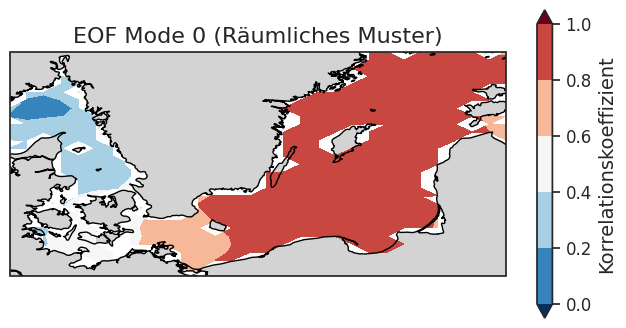

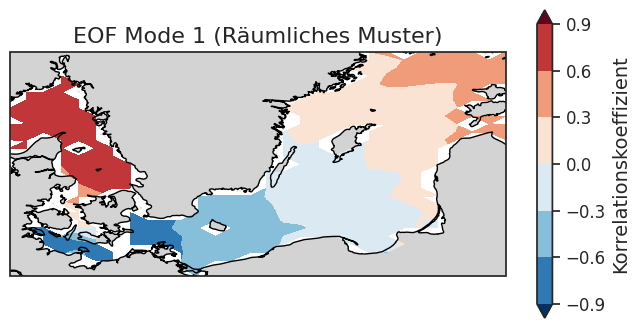

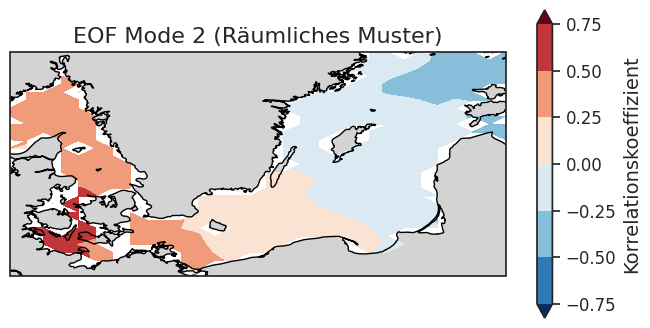

In [26]:
def plot_eof_map(mode=1, neofs=10):


    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    eofs = solver.eofsAsCorrelation(neofs=neofs)   # (mode:3, lat, lon)

    # Beispiel: Plot der ersten EOF-Map (Mode 1)
    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    eofs.sel(mode=mode).plot.contourf(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        extend='both',
        cbar_kwargs={'label': 'Korrelationskoeffizient'}
    )
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_title(f"EOF Mode {mode} (Räumliches Muster)")
    plt.show()
    plt.close()

for i in range(0, 3):
    plot_eof_map(mode=i, neofs=10)

In [14]:
# data vars to list 
data_vars = list(ds_ocean.data_vars)
data_vars

['bottomT', 'sla', 'so', 'sob', 'thetao', 'uo', 'vo', 'wo']

In [15]:
def eof_solver(ds, feature, center=False, n_modes=10):
    import numpy as np
    import xarray as xr
    from eofs.xarray import Eof
    import pandas as pd
    """
    Perform EOF analysis on a given feature of an xarray Dataset.
    """
    # Maske für gültige Ozeanpunkte
    mask = ~np.isnan(ds[feature].isel(time=0))
    ds_cleaned = ds[feature].where(mask)

    # Flächengewichtung nach Breite (broadcast auf (lat, lon))
    lat_deg = ds_cleaned["latitude"].values  # (n_lat,)
    weights_2d = np.sqrt(np.cos(np.deg2rad(lat_deg)))[:, np.newaxis]  # (n_lat, 1)

    # Eof-Objekt erzeugen
    solver = Eof(ds_cleaned, weights=weights_2d, center=center)
    return solver

def run_eof_reduction(ds, thresh=0.9):
    """ Perform EOF analysis on all data variables in the dataset and return a DataFrame with PCs."""

    import numpy as np
    import xarray as xr
    from eofs.xarray import Eof
    import pandas as pd

    # data vars to list
    data_vars = list(ds.data_vars)
    df_merged = pd.DataFrame({
        'time': ds['time'].values  # Zeitstempel als Basis für die Zusammenführung
    })  # Leeres DataFrame für die Zusammenführung
    for var in data_vars:

        # --- (A) Solver initialisieren ---
        # ds_cleaned: dein vorverarbeiteter DataArray oder Dataset (time, lat, lon), bereits anomaliesiert
        # weights: 1D-Array über latitude für Flächengewichtung (z.B. sqrt(cos(lat)))
        solver = eof_solver(ds, var, center=True)

        # --- (B) Varianzanteile anschauen, um k zu wählen ---
        navors = 30
        var_frac = solver.varianceFraction(neigs=navors)
        cumvar = var_frac.cumsum(dim="mode")

        thresh = 0.90  # Schwellenwert für kumulative Varianz
        # z.B. suche k, um ≥95 % abzudecken:
        k = int((cumvar >= thresh).argmax().item() + 1)
        #print(f"Modi für ≥95 % Varianz: {k}")


        # --- (C) PCs berechnen ---
        pcs  = solver.pcs(npcs=k, pcscaling=1)    # (time:20184, mode:3)

        # --- (E) PCs als reduzierte Features extrahieren ---
        # In pandas DataFrame umwandeln, so dass jede Mode eine Spalte wird:
        # PCs direkt in DataFrame umwandeln und Spalten sinnvoll benennen
        df_pc = pcs.to_pandas()
        df_pc.columns = [f'{var}_PC_{i+1}' for i in range(df_pc.shape[1])]
        df_pc = df_pc.reset_index()  # 'time' als Spalte



        # Merge PCS to one dataframe
        df_merged = pd.merge(df_merged, df_pc, on='time', how='outer')
    
    return df_merged

df_ocean_pc = run_eof_reduction(ds_ocean, thresh=0.9)
df_weather_pc = run_eof_reduction(ds_weather, thresh=0.9)

merged_pc = pd.merge(df_ocean_pc, df_weather_pc, on='time', how='outer')
merged_pc.dropna(inplace=True)



In [16]:
merged_pc.shape

(20161, 97)

In [17]:
merged_pc.dropna()

,time,bottomT_PC_1,bottomT_PC_2,bottomT_PC_3,bottomT_PC_4,sla_PC_1,sla_PC_2,sla_PC_3,so_PC_1,so_PC_2,so_PC_3,so_PC_4,so_PC_5,so_PC_6,so_PC_7,so_PC_8,so_PC_9,so_PC_10,so_PC_11,so_PC_12,so_PC_13,so_PC_14,so_PC_15,so_PC_16,so_PC_17,so_PC_18,so_PC_19,so_PC_20,so_PC_21,sob_PC_1,sob_PC_2,sob_PC_3,sob_PC_4,sob_PC_5,sob_PC_6,sob_PC_7,sob_PC_8,sob_PC_9,sob_PC_10,sob_PC_11,sob_PC_12,sob_PC_13,sob_PC_14,sob_PC_15,sob_PC_16,sob_PC_17,sob_PC_18,sob_PC_19,sob_PC_20,sob_PC_21,sob_PC_22,sob_PC_23,sob_PC_24,sob_PC_25,sob_PC_26,thetao_PC_1,uo_PC_1,vo_PC_1,wo_PC_1,wo_PC_2,wo_PC_3,wo_PC_4,wo_PC_5,wo_PC_6,wo_PC_7,pressure_msl_PC_1,pressure_msl_PC_2,surface_pressure_PC_1,surface_pressure_PC_2,wind_gusts_10m_PC_1,wind_gusts_10m_PC_2,wind_gusts_10m_PC_3,wind_gusts_10m_PC_4,wind_gusts_10m_PC_5,wind_gusts_10m_PC_6,wind_gusts_10m_PC_7,wind_gusts_10m_PC_8,wind_gusts_10m_PC_9,wind_gusts_10m_PC_10,wind_gusts_10m_PC_11,wind_gusts_10m_PC_12,wind_gusts_10m_PC_13,wind_gusts_10m_PC_14,wind_gusts_10m_PC_15,wind_u_PC_1,wind_u_PC_2,wind_u_PC_3,wind_u_PC_4,wind_u_PC_5,wind_v_PC_1,wind_v_PC_2,wind_v_PC_3,wind_v_PC_4,wind_v_PC_5,wind_v_PC_6,wind_v_PC_7,wind_v_PC_8
0,2022-12-03 00:00:00,-0.303945,-1.571631,-0.796631,0.568800,-1.005268,-0.822924,0.530070,-0.218220,-0.897083,0.492402,-1.479749,1.945935,-1.708837,0.830561,0.660026,0.225722,-0.037684,-1.047863,0.151338,0.904935,0.266220,1.443508,0.784207,0.407340,1.257197,1.615682,0.082208,0.839712,0.264553,0.254636,-1.669036,0.791188,-0.179636,0.022623,0.643463,-0.607757,-2.275575,-0.271110,2.232440,2.175432,1.667905,-1.114560,1.036917,-0.649352,0.085947,0.039516,0.149573,1.011663,0.578998,-1.767117,-0.969698,2.975066,-0.136664,0.596100,-0.332200,-1.676010,-0.916467,-0.988585,1.898465,2.087613,-0.664901,0.994255,0.952559,0.191309,-1.799356,0.820406,-1.776560,0.802997,0.307614,0.536856,-0.747929,0.936315,0.400297,0.801069,1.029647,0.212648,-0.014411,-0.890306,1.514957,-0.677087,-1.288168,-0.407751,0.588297,-1.480024,0.146613,-0.558169,-0.736164,0.621810,-0.910458,-1.380508,-0.336356,-0.663772,-0.176910,1.683785,0.216442,-1.537871
1,2022-12-03 01:00:00,-0.305888,-1.570625,-0.795225,0.571684,-1.002811,-0.833910,0.528256,-0.210618,-0.893305,0.481362,-1.521018,1.944044,-1.712570,0.832452,0.601833,0.220957,-0.069068,-1.055865,0.110541,0.909764,0.278798,1.370188,0.752076,0.372693,1.250635,1.550921,0.082548,0.713609,0.259735,0.271430,-1.669632,0.789600,-0.226949,0.082152,0.661515,-0.607035,-2.254747,-0.248653,2.227916,2.186811,1.623602,-1.106727,0.991440,-0.647355,0.070829,-0.006989,0.095796,0.979036,0.573021,-1.714309,-1.045219,3.015842,-0.200679,0.572013,-0.337065,-1.672298,-0.883804,-0.892139,1.448010,1.708405,-0.605668,0.497346,0.670010,0.041205,-1.783356,0.837623,-1.760595,0.820056,0.188744,0.553674,-0.678464,0.933067,0.280232,0.715765,0.946240,0.647390,-0.433782,-0.937278,1.574243,-0.163445,-1.523156,-0.419751,0.044024,-1.528717,0.085352,-0.516891,-0.761704,0.570615,-0.891139,-1.419401,-0.342445,-0.626422,-0.157994,1.578949,-0.004670,-1.594176
2,2022-12-03 02:00:00,-0.306904,-1.571336,-0.795739,0.570574,-1.006549,-0.904703,0.446098,-0.205510,-0.893562,0.476674,-1.559010,1.944211,-1.724287,0.846148,0.536701,0.206006,-0.078033,-1.056282,0.085108,0.891672,0.270216,1.303007,0.736780,0.342056,1.274352,1.523114,0.057399,0.650072,0.256050,0.284954,-1.667553,0.789894,-0.262441,0.130412,0.681979,-0.602594,-2.231523,-0.236153,2.221946,2.199752,1.607716,-1.141528,0.905202,-0.641713,0.067386,-0.032400,0.034161,0.940107,0.564657,-1.674537,-1.113952,3.037881,-0.231346,0.522573,-0.338199,-1.682788,-0.840234,-0.873372,1.393306,1.654720,-0.608534,0.437138,0.657030,-0.052356,-1.773908,0.849513,-1.751190,0.832466,0.157848,0.529108,-0.647984,1.040153,0.170379,0.686427,0.930924,0.619783,-0.394544,-0.846014,1.492404,-0.274645,-1.698443,-0.676209,0.439589,-1.560375,0.067863,-0.474704,-0.719649,0.507614,-0.854349,-1.451191,-0.345683,-0.446534,-0.018121,1.552726,-0.105363,-1.581817
3,2022-12-03 03:00:00,-0.308250,-1.573073,-0.795607,0.568620,-1.01

In [18]:
merged_pc.info()


<class 'pandas.core.frame.DataFrame'>
Index: 20161 entries, 0 to 20160
Data columns (total 97 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time                   20161 non-null  datetime64[ns]
 1   bottomT_PC_1           20161 non-null  float32       
 2   bottomT_PC_2           20161 non-null  float32       
 3   bottomT_PC_3           20161 non-null  float32       
 4   bottomT_PC_4           20161 non-null  float32       
 5   sla_PC_1               20161 non-null  float32       
 6   sla_PC_2               20161 non-null  float32       
 7   sla_PC_3               20161 non-null  float32       
 8   so_PC_1                20161 non-null  float32       
 9   so_PC_2                20161 non-null  float32       
 10  so_PC_3                20161 non-null  float32       
 11  so_PC_4                20161 non-null  float32       
 12  so_PC_5                20161 non-null  float32       
 13  so_PC_